In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import joblib



# EDA

In [39]:
df = pd.read_csv('eBird2023_cleaned.csv')
df = df.rename(columns={'comName':'species',
                        'lat':'latitude',
                        'lng':'longitude'})
df.head()

,speciesCode,species,sciName,locId,locName,obsDt,howMany,latitude,longitude,obsValid,obsReviewed,locationPrivate,subId,exoticCategory,week_number
0,snogoo,Snow Goose,Anser caerulescens,L2720609,Alta Sierra--Golf Course and neighborhoods,2023-01-01 22:59:00,70.0,39.13915,-121.053282,True,True,False,S125152458,NaN,52.0
1,mutswa,Mute Swan,Cygnus olor,L2720609,Alta Sierra--Golf Course and neighborhoods,2023-01-01 22:59:00,2.0,39.13915,-121.053282,True,True,False,S125152458,P,52.0
2,wooduc,Wood Duck,Aix sponsa,L2720609,Alta Sierra--Golf Course and neighborhoods,2023-01-01 22:59:00,5.0,39.13915,-121.053282,True,False,False,S125152458,NaN,52.0
3,mallar3,Mallard,Anas platyrhynchos,L2720609,Alta Sierra--Golf Course and neighborhoods,2023-01-01 22:59:00,2.0,39.13915,-121.053282,True,False,False,S125152458,NaN,52.0
4,rinduc,Ring-necked Duck,Aythya collaris,L2720609,Alta Sierra--Golf Course and neighborhoods,2023-01-01 22:59:00,35.0,39.13915,-121.053282,True,False,False,S125152458,NaN,52.0


In [40]:
print(df['species'].value_counts())

species
Black-billed Magpie        716
Steller's Jay              688
California Scrub-Jay       643
Common Merganser           627
California Quail           619
                          ... 
Stilt Sandpiper             26
Cassin's Kingbird           25
Eastern Phoebe              24
Scaly-breasted Munia        22
Flesh-footed Shearwater     10
Name: count, Length: 311, dtype: int64


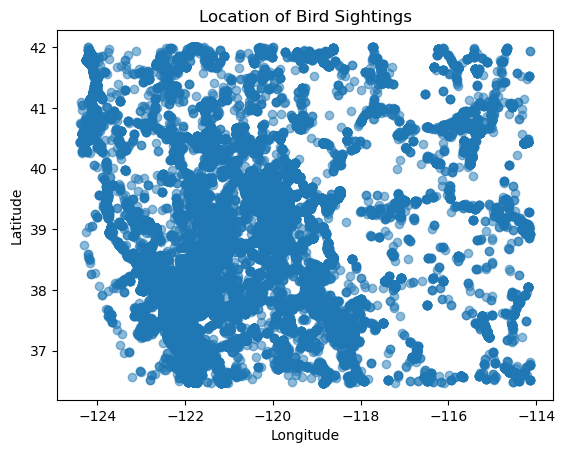

In [41]:
plt.scatter(df['longitude'], df['latitude'], alpha=0.5)
plt.title('Location of Bird Sightings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Modeling

In [42]:
df['observation'] = 1  # label currents obz as 1

# generate "negative" data points (locations with no obz), generate the same number of negative samples
num_negative_samples = len(df)  

# generate random locations for neg samps
neg_samples = pd.DataFrame({'latitude': np.random.uniform(df['latitude'].min(), df['latitude'].max(), num_negative_samples),
                            'longitude': np.random.uniform(df['longitude'].min(), df['longitude'].max(), num_negative_samples),
                            'observation': 0})  # label neg obz

# combine into a df
df_combined = pd.concat([df[['latitude', 'longitude', 'observation']], neg_samples], ignore_index=True)


In [43]:
# do sin/cos transofmrations
df_combined['lat_sin'] = np.sin(np.radians(df_combined['latitude']))
df_combined['lat_cos'] = np.cos(np.radians(df_combined['latitude']))
df_combined['lon_sin'] = np.sin(np.radians(df_combined['longitude']))
df_combined['lon_cos'] = np.cos(np.radians(df_combined['longitude']))

X = df_combined[['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos']]  
y = df_combined['observation']  

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42)
rf_binary.fit(X_train, y_train)

y_pred_rf_binary = rf_binary.predict(X_test)

print(f'Binary Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf_binary)}')
print(classification_report(y_test, y_pred_rf_binary))


Binary Random Forest Accuracy: 0.957651174126215
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     17405
           1       0.95      0.96      0.96     17472

    accuracy                           0.96     34877
   macro avg       0.96      0.96      0.96     34877
weighted avg       0.96      0.96      0.96     34877



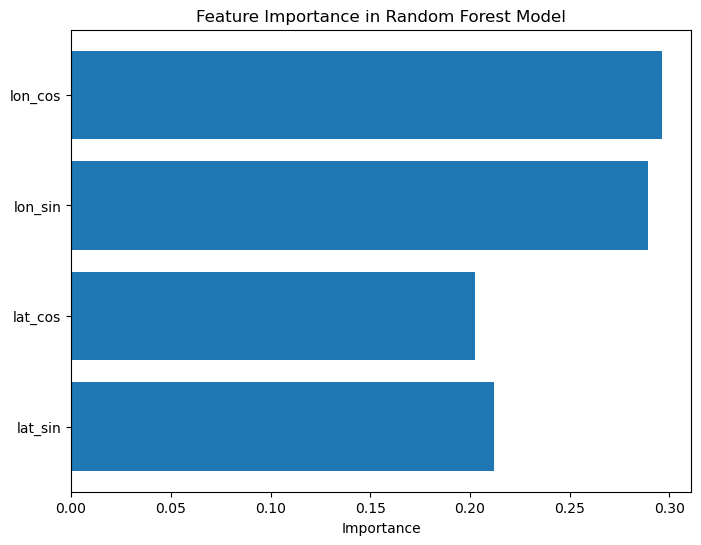

In [45]:
# get feature importances from model
importances = rf_binary.feature_importances_
feature_names = ['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos']

plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()

In [47]:
joblib.dump(rf_binary, 'bird_observation_model.pkl')

['bird_observation_model.pkl']